# Task 1 : char-rnn

This task involved running the code from Andrej Karpathy's repository. However, the code is a legacy version with most of it's functionalities deprecated. So, the code the implemented from scratch, with all the original requirements.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import requests
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We'll first download the text file from the repository. The following snippet performs that.

In [ ]:
def download_tiny_shakespeare(url="https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt", file_name="tinyshakespeare.txt"):
    response = requests.get(url)
    response.raise_for_status()  # Check if the download was successful

    with open(file_name, 'w') as f:
        f.write(response.text)

    print(f"Downloaded Tiny Shakespeare dataset and saved as {file_name}")
download_tiny_shakespeare()

Downloaded Tiny Shakespeare dataset and saved as tinyshakespeare.txt


To streamline the pytorch pipeline, we need to feed the text data through the standardised Dataset class (inherited from `torch.utils.data`) and Dataloader.

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, path, chunk_size=200):  # chunk_size is the number of characters in each chunk
        with open(path, 'r', encoding='utf-8') as f:
            text = f.read()

        self.vocab = sorted(set(text))  # Create a list of unique characters
        self.vocab_size = len(self.vocab)  # Get the number of unique characters
        self.char_to_index = {ch: idx for idx, ch in enumerate(self.vocab)}  # Create a dictionary so that we can get the index of any character
        self.index_to_char = {idx: ch for idx, ch in enumerate(self.vocab)}  # Create a dictionary so that we can get the character of any index

        self.data = [self.char_to_index[char] for char in text] # Create a list of indices for each character
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.data) // self.chunk_size

    #For language modeling task, the ouput is basically the input text, offset by one letter ahead. 
    def __getitem__(self, idx):
        chunk = self.data[idx*self.chunk_size:(idx+1)*self.chunk_size]
        input_seq = torch.tensor(chunk[:-1], dtype=torch.long)
        target_seq = torch.tensor(chunk[1:], dtype=torch.long)
        return input_seq, target_seq

def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=0)
    return input_seqs, target_seqs

We'll now create the model. RNN layer is set to either LSTM or the vanilla variant depending on need.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout=0.5, rnn_type='LSTM'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type. Choose either 'LSTM' or 'RNN'.")
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

Small snippet to generate text from a trained model.

In [1]:
def generate_text(model, dataset, device, seed_text='The', sequence_length=100):
    model.to(device)
    model.eval()
    indices = [dataset.char_to_index[char] for char in seed_text]
    input_seq = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    text_generated = seed_text

    with torch.no_grad():
        for _ in range(sequence_length):
            output, _ = model(input_seq)
            output = output[:, -1, :]
            predicted_index = output.argmax(1).item()
            text_generated += dataset.index_to_char[predicted_index]

            input_seq = torch.cat([input_seq, torch.tensor([[predicted_index]], device=device)], dim=1)
    return text_generated

In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs=501, device=torch.device('cpu')):
    model.train()
    model.to(device)
    losses = []
    progress_bar = tqdm(range(epochs), desc='Training Progress')
    for epoch in progress_bar:
        total_loss = 0
        for input_seq, target_seq in dataloader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            optimizer.zero_grad()
            output, _ = model(input_seq)
            loss = criterion(output.transpose(1, 2), target_seq)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_loss = total_loss / len(dataloader)
        losses.append(epoch_loss)
        progress_bar.set_postfix({'epoch': epoch + 1, 'loss': epoch_loss})
        if (epoch+1) in [5, 50, 100, 200, 250, 300, 400, 500]:  # Adjust this list based on the epochs you're interested in
            torch.save(model.state_dict(), f'lstm_epoch_{epoch+1}.pth')
            # Evaluate model and print text here if needed
            model.eval()
            generated_text = generate_text(model, dataset, device, seed_text="The", sequence_length=100)
            print(f'\nGenerated Text at Epoch {epoch + 1}: {generated_text}\n')
            model.train()
    return losses

In [ ]:
dataset = ShakespeareDataset("tinyshakespeare.txt", chunk_size=200)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

For language modeling task, the ouput is basically the input text, offset by one letter ahead. We can see that from the follwing sample.

In [ ]:
for input_seq, target_seq in dataloader:
    sample_input_seq, sample_target_seq = input_seq[0], target_seq[0]
    break

sample_input_text = ''.join([dataset.index_to_char[idx.item()] for idx in sample_input_seq])
sample_target_text = ''.join([dataset.index_to_char[idx.item()] for idx in sample_target_seq])

print(f"Sample Input :\n{sample_input_text}\n\n")
print(f"Sample Target :\n{sample_target_text}")

Sample Input :
led mind drave me to walk abroad;
Where, underneath the grove of sycamore
That westward rooteth from the city's side,
So early walking did I see your son:
Towards him I made, but he was ware of me
An


Sample Target :
ed mind drave me to walk abroad;
Where, underneath the grove of sycamore
That westward rooteth from the city's side,
So early walking did I see your son:
Towards him I made, but he was ware of me
And


We'll first run the vanilla RNN with the following hyper-parameters (similar to original repo). 

In [ ]:
model = RNNModel(vocab_size=1000, embed_dim=256, hidden_dim=512, n_layers=2, dropout=0.5, rnn_type='RNN')
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

Training Progress:   1%|          | 5/501 [00:13<22:49,  2.76s/it, epoch=5, loss=1.58]


Generated Text at Epoch 5: The see the sease the sease the sease the sease the sease the sease the sease the sease the sease the s



Training Progress:  10%|▉         | 50/501 [02:07<19:20,  2.57s/it, epoch=50, loss=1.45]


Generated Text at Epoch 50: The words of the world to the world to the world to the world to the world to the world to the world to



Training Progress: 100%|█████████▉| 500/501 [21:03<00:02,  2.57s/it, epoch=500, loss=2.22]


Generated Text at Epoch 500: Ther the sou the sou the sou the sou the sou the sou the sou the sou the sou the sou the sou the sou th



Training Progress: 100%|██████████| 501/501 [21:06<00:00,  2.53s/it, epoch=501, loss=2.21]


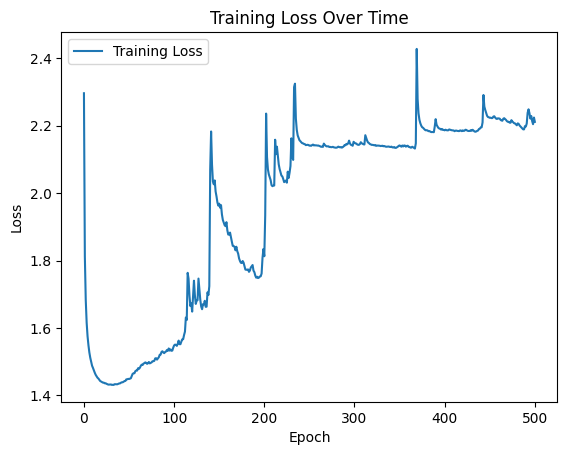

In [ ]:
losses = train_model(model, dataloader, criterion, optimizer, epochs=501, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

Vanilla RNN clearly has some issues with it's implementation. Some possible reasons that could be hypothesized are
- **Learning Rate**: A learning rate that's too high can cause the loss to fluctuate widely
- Possible exploding gradients.
- Dropout rate may be too high.
- Seeing the generated text, it looks like model is memorizing the text (overfitting)

We'll observe the same setup for LSTM model now.

Training Progress:   1%|          | 5/501 [00:16<27:48,  3.36s/it, epoch=5, loss=1.68]


Generated Text at Epoch 5: The shall be the son the son the son the son the son the son the son the son the son the son the son th



Training Progress:  10%|▉         | 50/501 [02:44<25:16,  3.36s/it, epoch=50, loss=1.26]


Generated Text at Epoch 50: The world that hath been to be a sight of the common soul and the common soul and the common souls
That



Training Progress: 100%|█████████▉| 500/501 [27:27<00:03,  3.35s/it, epoch=500, loss=1.16]


Generated Text at Epoch 500: The would die the deep deed.

GLOUCESTER:
Ay, but thou hast slain to her the compass.

KING RICHARD II:



Training Progress: 100%|██████████| 501/501 [27:31<00:00,  3.30s/it, epoch=501, loss=1.18]


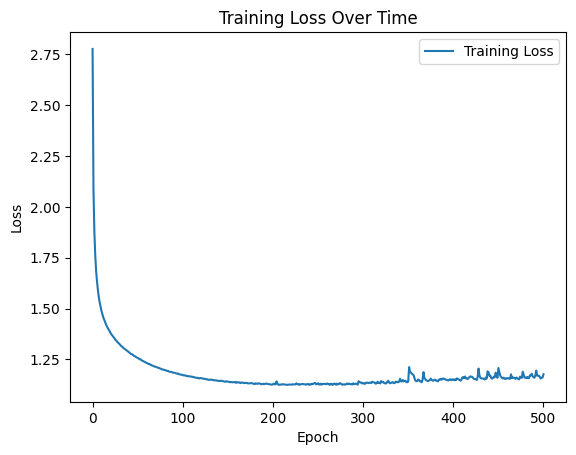

In [ ]:
model = RNNModel(vocab_size=1000, embed_dim=256, hidden_dim=512, n_layers=2, dropout=0.5, rnn_type='LSTM')
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()
losses = train_model(model, dataloader, criterion, optimizer, epochs=501, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

This definitely has much better performance. The training curve also seems to be stable enough. The quality in the generated text is also significantly superior.
In the begining, the model seems to memorize the text (can be seen in Epoch 5 generation. However, with later epochs, it seems to have grasped richer vocabulary, and finally with Epoch 500, it seems to also include the style of Shakespeare's works.